# U-NET

In [40]:
import numpy
import matplotlib.pyplot as plt
import os 
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import PIL
from PIL import Image

# GPU

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset y Dataloader

In [42]:
base_path = 'C:\\Users\\sebas\\Code\\Personal\\DeepLearning\\bomboclat-deep-learning\\data'
TRAIN_PATH = os.path.join(base_path, 'imagenes')
TRAIN_MASKS_PATH = os.path.join(base_path, 'mascaras')


### Dataset

In [43]:
# creamos nuestro propio Dataset
class CustomDataset(Dataset):
    def __init__(self, data_path, masks_path, img_transforms=None, mask_transforms=None):
        """
        data_path - train data path
        masks_path - train masks path
        """
        self.train_data = data_path
        self.train_masks = masks_path

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images) == len(self.masks), 'Not the same number of images and masks'
        return len(self.images)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = trans(img)

        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            # Normalizamos las mascaras para que sean 0s y 1s, estamos segmentando glaciares
            mask_max = mask.max().item()
            mask = mask/mask_max
        else:
            return img
        
        return img, mask

### Transformaciones

In [44]:
transform_data = T.Compose([
    T.Resize([224, 224]),	
    T.ToTensor(),
])

### Dataloaders

In [45]:
full_dataset = CustomDataset(TRAIN_PATH, TRAIN_MASKS_PATH, img_transforms=transform_data, mask_transforms=transform_data)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
BATCH_SIZE = 16

In [46]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [47]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])


In [48]:
for i, (x, y) in enumerate (train_loader):
    print(i, x.shape, y.shape)
    if i == 9:
        break

0 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
1 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
2 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
3 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
4 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
5 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
6 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
7 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
8 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
9 torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])


### Veamos la data

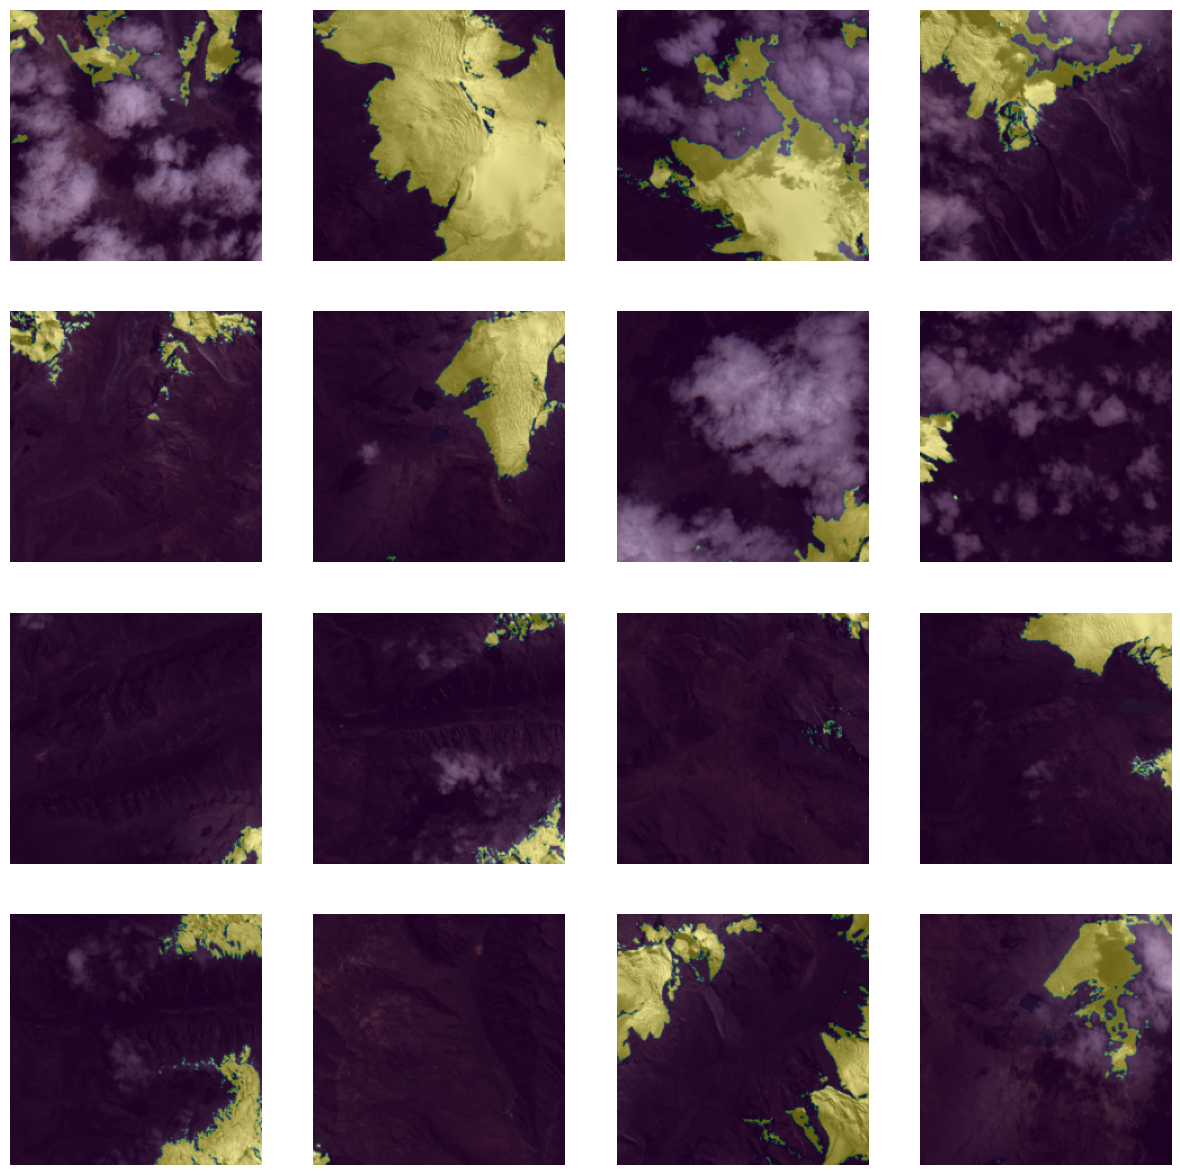

In [49]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(imgs[i*4+j].permute(1, 2, 0))
            axs[i, j].imshow(masks[i*4+j].permute(1, 2, 0).squeeze(), alpha=0.4)
            axs[i, j].axis('off')
    plt.show()
plot_mini_batch(imgs, masks)

# Implementación del modelo

### Accuracy

In [50]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost += F.cross_entropy(scores, y).item()
            # Standard accuracy calculation
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            # Dice coefficient calculation
            intersection += (preds * y).sum()
            denom += (preds + y).sum()
            dice = 2 * intersection / (denom + 1e-8)
            # IoU calculation
            union += (preds | y).sum()
            iou = intersection / (union + 1e-8)
    return cost / len(loader), float(correct) / total, dice.item(), iou.item()

### Search for Learning Rate

In [51]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

### Train loop

In [52]:
def train(model, optimizer, scheduler = None, epochs=100, store_every=25):
    model = model.to(device= device) # Activamos el gpu
    for epoch in range(epochs):
        train_correct_num = 0   # Numero de predicciones correctas
        train_total = 0 # Numero total de predicciones
        train_cost_acum = 0. # Costo acumulado
        for mb, (x, y) in enumerate (train_loader, start=1): # Iteramos sobre los minibatches
            model.train() # Activamos el modo de entrenamiento
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1) # Eliminamos la dimension de canal
            scores = model(x)
            cost = F.cross_entropy(scores, y)
            optimizer.zero_grad() # Limpiamos los gradientes
            cost.backward() # Calculamos los gradientes
            optimizer.step() # Actualizamos los pesos
            if scheduler: 
                scheduler.step() # Actualizamos el learning rate
            train_predictions = torch.argmax(scores, dim=1) # Obtenemos las predicciones
            train_correct_num += (train_predictions == y).sum() # Sumamos las predicciones correctas
            train_total += torch.numel(train_predictions) # Sumamos el numero total de predicciones
            train_cost_acum += cost.item() # Sumamos el costo
            if mb % store_every == 0: # Cada ciertos minibatches calculamos el costo y la accuracy de validacion
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num) / train_total
                train_cost = float(train_cost_acum) / mb
                print(f'Epoch {epoch}, minibatch {mb}, train cost {train_cost:.3f}, train acc {train_acc:.3f}, val cost {val_cost:.3f}, val acc {val_acc:.3f}, dice {dice:.3f}, iou {iou:.3f}')
        # Save model
        #torch.save(model.state_dict(), 'model.pth')

### U-NET model

In [53]:
class Conv_3_kernel(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Mantenemos el tamaño de la imagen con padding 1 y stride 1
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        return self.conv1(x)

In [54]:
class Double_Conv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Agregamos batch notmalization para permitir learning rates altos y reducir la dependencia de la inicialización
        self.double_conv = nn.Sequential(
            Conv_3_kernel(channels_in, channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),

            Conv_3_kernel(channels_out, channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [55]:
class Down_Conv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Reducimos el tamaño de la imagen a la mitad con un kernel de 2 y stride 2
        self.encoder = nn.Sequential(      
            nn.MaxPool2d(kernel_size=2, stride=2),
            Double_Conv(channels_in, channels_out)
        )

    def forward(self, x):
        return self.encoder(x)

In [56]:
# Implementamos el Up_Conv original del paper
class Up_Conv(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Aumentamos el tamaño de la imagen a la mitad con un kernel de 2 y stride 2
        self.conv_transpose_layer = nn.ConvTranspose2d(channels_in, channels_out, kernel_size=2, stride=2)
        self.decoder = Double_Conv(channels_in, channels_out)
        
    def forward(self, x1, x2):
        x1 = self.conv_transpose_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)

In [57]:
class Up_Conv_Mejorado(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        # Con upsample y convolución de 1x1 recuperamos las imagenes con mejor resolución y menos ruido, además de reducir la cantidad de canales a la mitad
        self.upsample_layer = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic'),
            nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
        )
        self.decoder = Double_Conv(channels_in, channels_out)


    def forward(self, x1, x2):
        """
        x1 = upsampled volume
        x2 = volume from downsample to concatenate
        """
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.decoder(x)

In [58]:
class UNET(nn.Module):
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.firs_conv = Double_Conv(channels_in, channels) # 64, 224, 224
        self.down1 = Down_Conv(channels, channels*2) # 128, 112, 112
        self.down2 = Down_Conv(channels*2, channels*4) # 256, 56, 56
        self.down3 = Down_Conv(channels*4, channels*8) # 512, 28, 28
        
        self.middle = Down_Conv(channels*8, channels*16) # 1024, 14, 14

        self.up1 = Up_Conv_Mejorado(channels*16, channels*8) # 512, 28, 28
        self.up2 = Up_Conv_Mejorado(channels*8, channels*4) # 256, 56, 56
        self.up3 = Up_Conv_Mejorado(channels*4, channels*2) # 128, 112, 112
        self.up4 = Up_Conv_Mejorado(channels*2, channels) # 64, 224, 224

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1) # 2, 224, 224

    def forward(self, x):
        x1 = self.firs_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.middle(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.last_conv(x)
        return x

In [59]:
def test():
    model = UNET(3, 64, 2)
    x = torch.randn(16, 3, 224, 224)
    return model(x)
    
preds = test()

In [60]:
print(preds.shape)

torch.Size([16, 2, 224, 224])


### Train model

In [61]:
torch.manual_seed(42)
model = UNET(3, 4, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lg_lrs, losses, accs = find_lr(model, optimizer, start_val=1e-6, end_val=1, loader=train_loader)

cost:0.9347, lr: 0.0000, acc: 0.0805
cost:0.9936, lr: 0.0000, acc: 0.0533
cost:1.0068, lr: 0.0000, acc: 0.0436
cost:0.9576, lr: 0.0000, acc: 0.0715
cost:0.9596, lr: 0.0000, acc: 0.0629
cost:0.9519, lr: 0.0000, acc: 0.0690
cost:0.9692, lr: 0.0000, acc: 0.0617
cost:0.9527, lr: 0.0000, acc: 0.0631
cost:0.9986, lr: 0.0000, acc: 0.0455
cost:0.9937, lr: 0.0000, acc: 0.0468
cost:0.9579, lr: 0.0000, acc: 0.0622
cost:0.9642, lr: 0.0000, acc: 0.0578
cost:0.9870, lr: 0.0000, acc: 0.0479
cost:0.9875, lr: 0.0000, acc: 0.0405
cost:0.9631, lr: 0.0001, acc: 0.0608
cost:0.9069, lr: 0.0001, acc: 0.0816
cost:0.9066, lr: 0.0001, acc: 0.0732
cost:0.8778, lr: 0.0001, acc: 0.0796
cost:0.9238, lr: 0.0002, acc: 0.0597
cost:0.9111, lr: 0.0002, acc: 0.0575
cost:0.9226, lr: 0.0003, acc: 0.0426
cost:0.8599, lr: 0.0004, acc: 0.0680
cost:0.8723, lr: 0.0005, acc: 0.0498
cost:0.8568, lr: 0.0007, acc: 0.0458
cost:0.7788, lr: 0.0009, acc: 0.0931
cost:0.8034, lr: 0.0012, acc: 0.0651
cost:0.7803, lr: 0.0015, acc: 0.0731
c

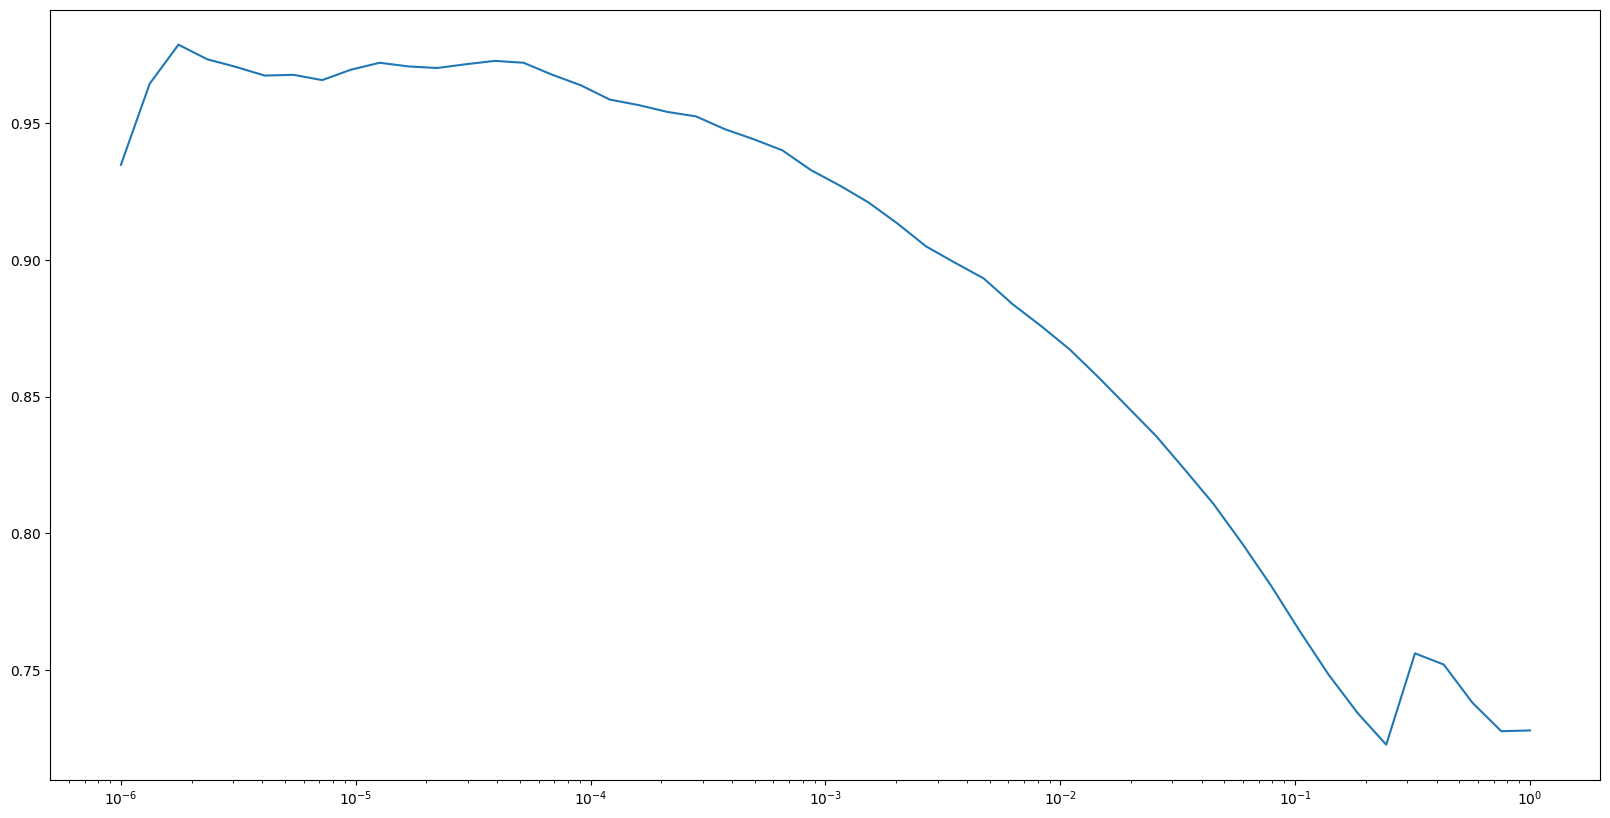

In [62]:
# plot loss vs lr
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(lg_lrs, losses)
ax1.set_xscale('log')
plt.show()

In [63]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 15
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, steps_per_epoch=len(train_loader), epochs=epochs,
                                                pct_start=0.43, div_factor=10, final_div_factor=1000, three_phase=True)

In [64]:
train(model, optimizer, scheduler, epochs=epochs)

Epoch 0, minibatch 25, train cost 0.464, train acc 0.806, val cost 0.290, val acc 0.892, dice 0.675, iou 0.509
Epoch 0, minibatch 50, train cost 0.345, train acc 0.859, val cost 0.228, val acc 0.903, dice 0.752, iou 0.603
Epoch 1, minibatch 25, train cost 0.189, train acc 0.917, val cost 0.230, val acc 0.893, dice 0.680, iou 0.515
Epoch 1, minibatch 50, train cost 0.197, train acc 0.912, val cost 0.246, val acc 0.887, dice 0.687, iou 0.523
Epoch 2, minibatch 25, train cost 0.204, train acc 0.905, val cost 0.273, val acc 0.883, dice 0.617, iou 0.446
Epoch 2, minibatch 50, train cost 0.205, train acc 0.905, val cost 0.207, val acc 0.906, dice 0.730, iou 0.575
Epoch 3, minibatch 25, train cost 0.168, train acc 0.924, val cost 0.215, val acc 0.901, dice 0.723, iou 0.566
Epoch 3, minibatch 50, train cost 0.189, train acc 0.914, val cost 0.215, val acc 0.899, dice 0.742, iou 0.590
Epoch 4, minibatch 25, train cost 0.184, train acc 0.916, val cost 0.207, val acc 0.900, dice 0.710, iou 0.551
E

### Ploteando algunos resultados

torch.Size([16, 224, 224])


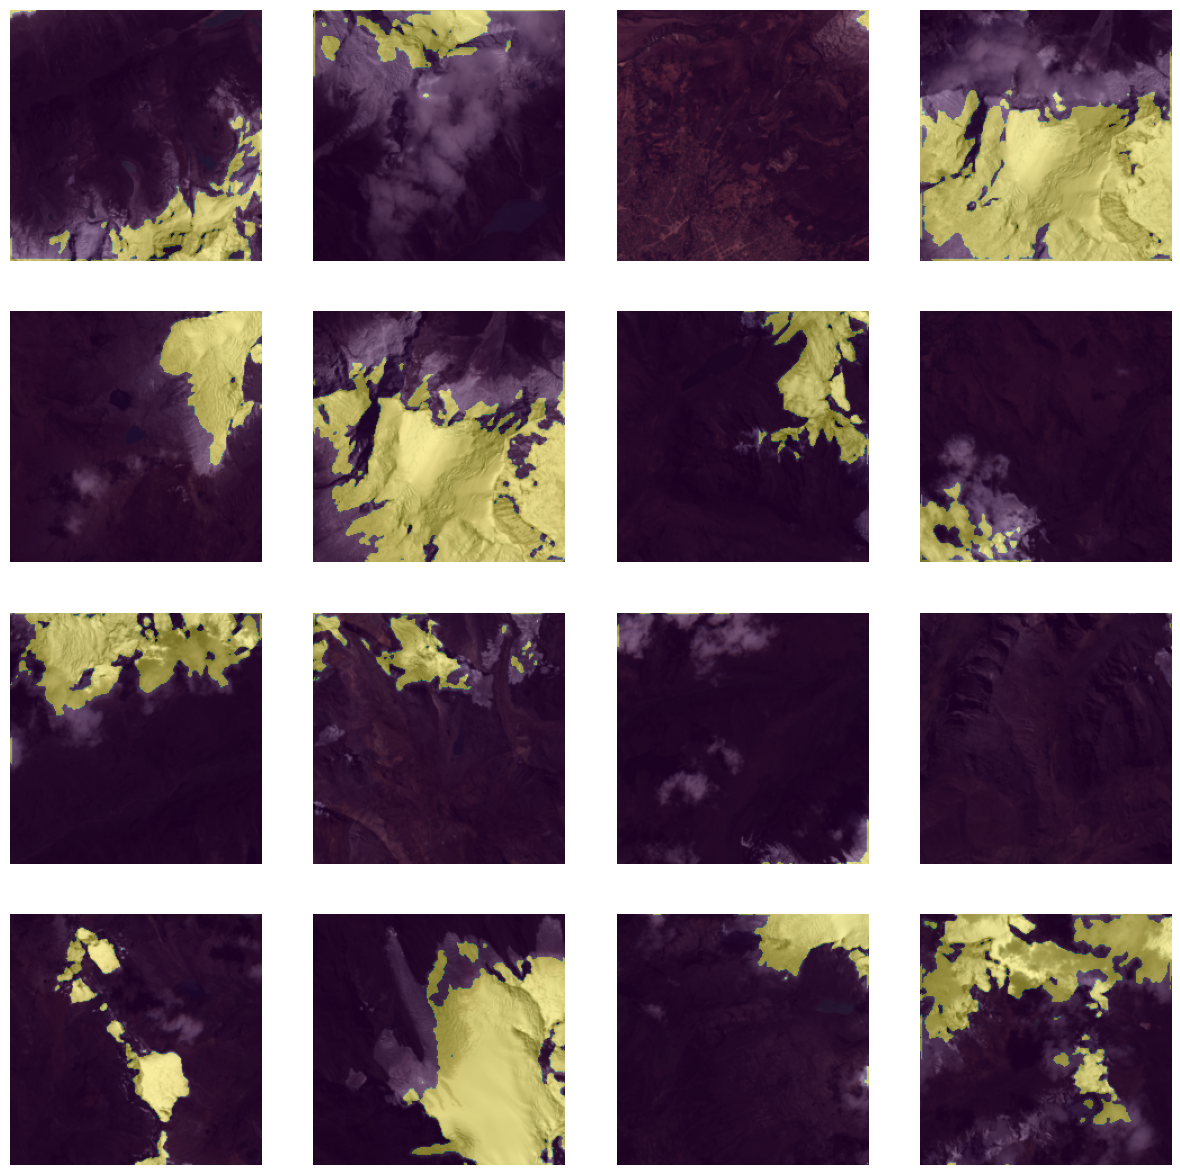

In [65]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

### Métricas

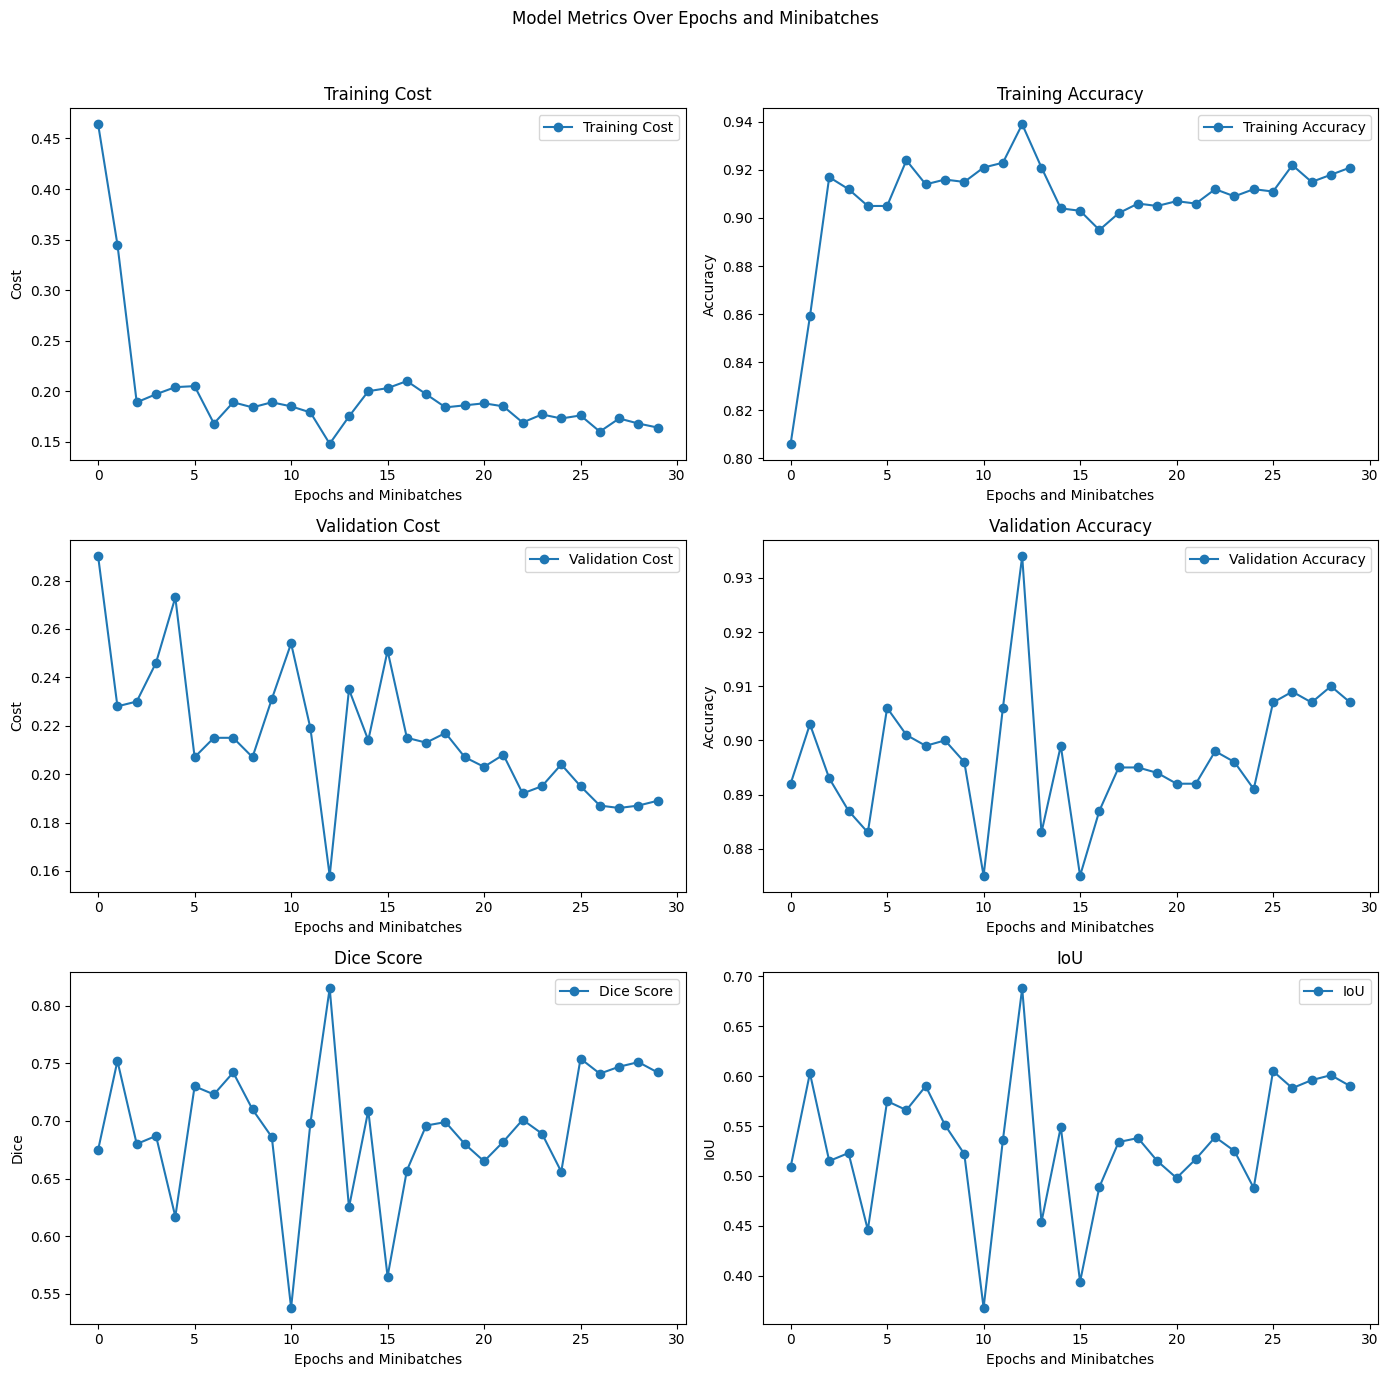

In [66]:
import matplotlib.pyplot as plt

# Data for metrics over epochs and minibatches
epochs = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14]
minibatches = [25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50, 25, 50]
train_costs = [0.464, 0.345, 0.189, 0.197, 0.204, 0.205, 0.168, 0.189, 0.184, 0.189, 0.185, 0.179, 0.148, 0.175, 0.200, 0.203, 0.210, 0.197, 0.184, 0.186, 0.188, 0.185, 0.169, 0.177, 0.173, 0.176, 0.160, 0.173, 0.168, 0.164]
train_accuracies = [0.806, 0.859, 0.917, 0.912, 0.905, 0.905, 0.924, 0.914, 0.916, 0.915, 0.921, 0.923, 0.939, 0.921, 0.904, 0.903, 0.895, 0.902, 0.906, 0.905, 0.907, 0.906, 0.912, 0.909, 0.912, 0.911, 0.922, 0.915, 0.918, 0.921]
val_costs = [0.290, 0.228, 0.230, 0.246, 0.273, 0.207, 0.215, 0.215, 0.207, 0.231, 0.254, 0.219, 0.158, 0.235, 0.214, 0.251, 0.215, 0.213, 0.217, 0.207, 0.203, 0.208, 0.192, 0.195, 0.204, 0.195, 0.187, 0.186, 0.187, 0.189]
val_accuracies = [0.892, 0.903, 0.893, 0.887, 0.883, 0.906, 0.901, 0.899, 0.900, 0.896, 0.875, 0.906, 0.934, 0.883, 0.899, 0.875, 0.887, 0.895, 0.895, 0.894, 0.892, 0.892, 0.898, 0.896, 0.891, 0.907, 0.909, 0.907, 0.910, 0.907]
dice_scores = [0.675, 0.752, 0.680, 0.687, 0.617, 0.730, 0.723, 0.742, 0.710, 0.686, 0.538, 0.698, 0.815, 0.625, 0.709, 0.565, 0.657, 0.696, 0.699, 0.680, 0.665, 0.682, 0.701, 0.689, 0.656, 0.754, 0.741, 0.747, 0.751, 0.742]
ious = [0.509, 0.603, 0.515, 0.523, 0.446, 0.575, 0.566, 0.590, 0.551, 0.522, 0.368, 0.536, 0.688, 0.454, 0.549, 0.394, 0.489, 0.534, 0.538, 0.515, 0.498, 0.517, 0.539, 0.525, 0.488, 0.605, 0.588, 0.596, 0.601, 0.590]

# Plotting the metrics
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle('Model Metrics Over Epochs and Minibatches')

# Training Cost
axes[0, 0].plot(range(len(train_costs)), train_costs, label='Training Cost', marker='o')
axes[0, 0].set_title('Training Cost')
axes[0, 0].set_xlabel('Epochs and Minibatches')
axes[0, 0].set_ylabel('Cost')
axes[0, 0].legend()

# Training Accuracy
axes[0, 1].plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy', marker='o')
axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epochs and Minibatches')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Validation Cost
axes[1, 0].plot(range(len(val_costs)), val_costs, label='Validation Cost', marker='o')
axes[1, 0].set_title('Validation Cost')
axes[1, 0].set_xlabel('Epochs and Minibatches')
axes[1, 0].set_ylabel('Cost')
axes[1, 0].legend()

# Validation Accuracy
axes[1, 1].plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy', marker='o')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epochs and Minibatches')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Dice Score
axes[2, 0].plot(range(len(dice_scores)), dice_scores, label='Dice Score', marker='o')
axes[2, 0].set_title('Dice Score')
axes[2, 0].set_xlabel('Epochs and Minibatches')
axes[2, 0].set_ylabel('Dice')
axes[2, 0].legend()

# IoU
axes[2, 1].plot(range(len(ious)), ious, label='IoU', marker='o')
axes[2, 1].set_title('IoU')
axes[2, 1].set_xlabel('Epochs and Minibatches')
axes[2, 1].set_ylabel('IoU')
axes[2, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [67]:
# Final values of the metrics
final_epoch = epochs[-1]
final_minibatch = minibatches[-1]
final_train_cost = train_costs[-1]
final_train_acc = train_accuracies[-1]
final_val_cost = val_costs[-1]
final_val_acc = val_accuracies[-1]
final_dice = dice_scores[-1]
final_iou = ious[-1]

print(f"Final metrics at Epoch {final_epoch}, Minibatch {final_minibatch}:")
print(f"Train Cost: {final_train_cost:.3f}")
print(f"Train Accuracy: {final_train_acc:.3f}")
print(f"Validation Cost: {final_val_cost:.3f}")
print(f"Validation Accuracy: {final_val_acc:.3f}")
print(f"Dice Score: {final_dice:.3f}")
print(f"IoU: {final_iou:.3f}")


Final metrics at Epoch 14, Minibatch 50:
Train Cost: 0.164
Train Accuracy: 0.921
Validation Cost: 0.189
Validation Accuracy: 0.907
Dice Score: 0.742
IoU: 0.590
